In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import src.utils.extractor as extractor
import src.training.data_augmentation as data_aug

In [6]:
def generate_hsi(h=9,w=9,b=4):
    hsi = torch.zeros(b, h, w)

    # Base checkerboard pattern
    # checkerboard = torch.zeros(h, w)
    # for i in range(h):
    #     for j in range(w):
    #         checkerboard[i, j] = (i + j) % 2
    
    checkerboard = torch.zeros(h, w)
    for i in range(h):
        for j in range(w):
            checkerboard[i, j] = (i + j) % 2

    # Generate slightly varying values for each tile
    checkerboard_varied = torch.zeros(h, w)
    for i in range(h):
        for j in range(w):
            base_value = checkerboard[i, j]  # Base value: 0 or 1
            perturbation = torch.rand(1).item() * 0.2 - 0.1  # Small random perturbation between -0.1 and 0.1
            checkerboard_varied[i, j] = base_value + perturbation  # Clamp to [0, 1]
    checkerboard = checkerboard_varied
    
    # Generate variations for each channel
    for k in range(b):
        # Random scaling and offset for each channel
        scale = torch.rand(1).item() * 0.5 + 0.5  # Scale between 0.5 and 1.0
        offset = torch.rand(1).item() * 0.2       # Offset between 0 and 0.2

        # Apply variation to the checkerboard
        hsi[k, :, :] = (checkerboard * scale + offset).clamp(0, 1)

    # Normalize each spectral vector to sum to 1
    hsi = hsi / hsi.sum(dim=0, keepdim=True)

    return hsi

y = generate_hsi(h=32, w=32, b=15)
b, h, w = y.shape

In [7]:
n_em = 6
n_vca = 10
n_aug_em = 10

vca = extractor.VCA()
endmember_lib = torch.tensor([])

for n in range(n_vca):
    e = vca.extract_endmembers(y, c=n_em)
    # print(e.shape)
    endmember_lib = torch.cat((endmember_lib, e), dim=1)

unique_spectra = data_aug.remove_duplicates(endmember_lib, tol=1e-5)
norms = torch.linalg.norm(unique_spectra, dim=1, keepdim=True)
unique_spectra_norm = unique_spectra / norms

centers, memberships = data_aug.group_spectra_kmeans(unique_spectra_norm.T, n_clusters=n_em)
grouped_lib = data_aug.group_spectra_by_cluster(unique_spectra_norm, memberships) # shape (n_em, nb_spectra_in_cluster, b)

augmented_lib = [
    torch.cat([torch.stack([data_aug.augment_spectrum(group[:, i]) for _ in range(n_aug_em)], dim=1)
               for i in range(group.shape[1])], dim=1)
for group in grouped_lib]

e_avg = torch.stack([torch.mean(augmented_lib[i], dim=1, keepdim=True) for i in range(n_em)], dim=1).squeeze(2)
e_avg.shape

input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 972, 540,  61, 410, 950])
input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 540, 410, 972, 950,  61])
input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 540, 410, 950,  61, 972])
input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 410, 540, 950, 972,  61])
input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 540, 410, 972,  61, 950])
input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 993, 540, 538, 972, 950])
input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 540, 278,  61, 950, 972])
input SNR estimated = 60.784034729003906[dB]
Indices chosen to be the most pure: tensor([529, 540, 410,  61, 950, 972])
input SNR estimated = 60.784034729003906

torch.Size([15, 6])

In [13]:
import pywt

x = [i for i in range(10)]

# DWT of x using bior3.3
xA, xD = pywt.dwt(x, 'bior3.3')

# IDWT of xA and xD using bior3.3
x_hat = pywt.idwt(xA, xD, 'bior3.3')

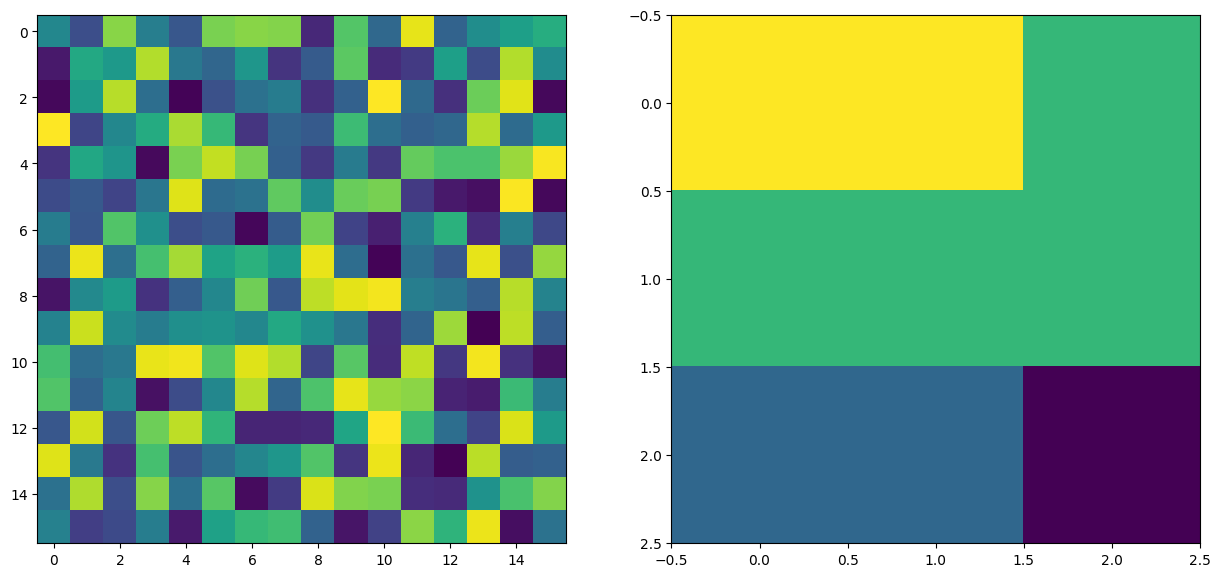

In [14]:
import torch
import matplotlib.pyplot as plt
import data_augmentation as aug

y = 256*torch.rand(4, 16, 16)
y1 = torch.tensor([[3,3,2], [2, 2, 2], [1, 1, 0]])
y1 = y1.unsqueeze(0).repeat(4, 1, 1)

fig, axs = plt.subplots(1,2, figsize=(15,10))
axs[0].imshow(y[0,:,:])
axs[1].imshow(y1[0,:,:])

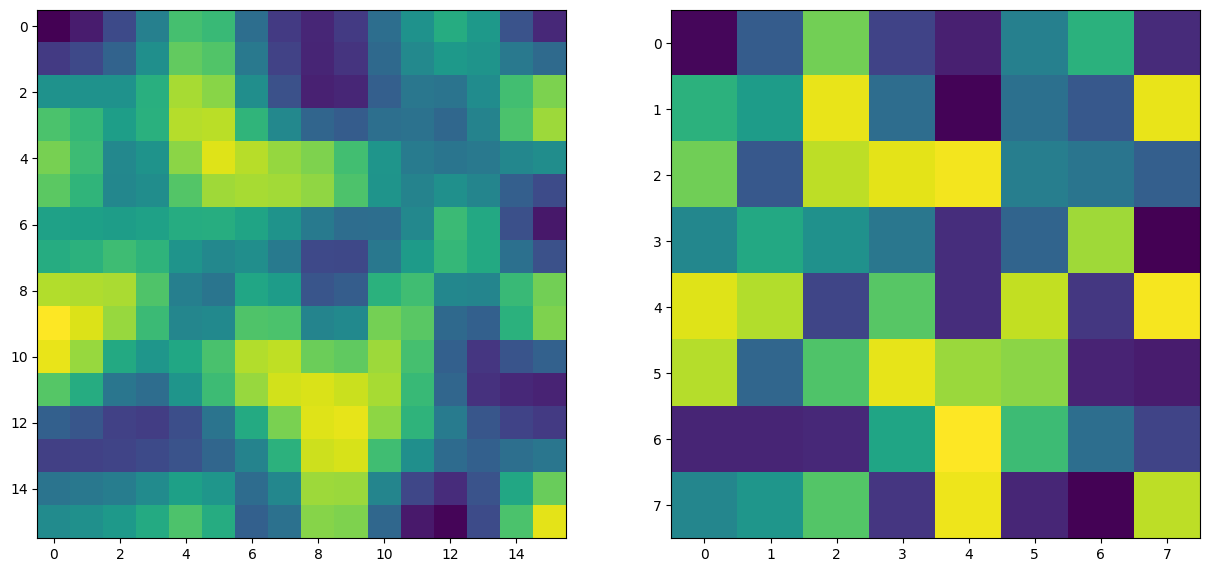

In [15]:
y2, (x_,y_), (r1,r2) = aug.crop_and_resize(y, 0.5, return_position=True)

fig, axs = plt.subplots(1,2, figsize=(15,10))
axs[0].imshow(y2[0,:,:])
axs[1].imshow(y[0,x_:x_+r1,y_:y_+r2])

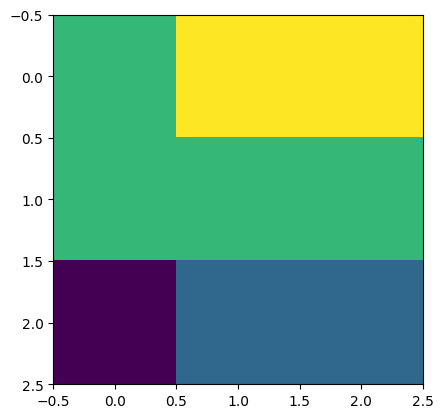

In [16]:
y3 = aug.flip(y1)

plt.imshow(y3[0,:,:])

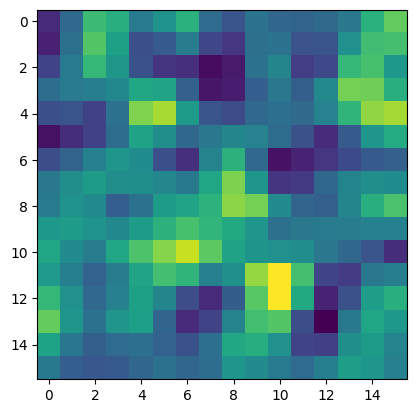

In [17]:
y4 = aug.blur(y, r=3, sigma=0.9)

plt.imshow(y4[0,:,:])

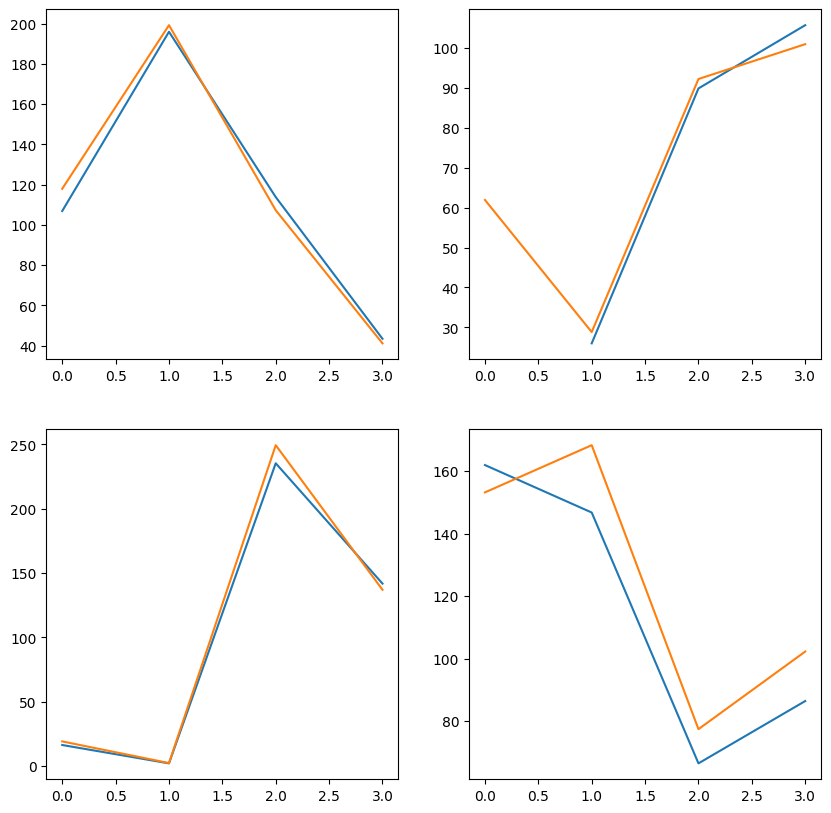

In [18]:
y5 = aug.spectral_variability(y, 0.4)

fig, axs = plt.subplots(2,2, figsize=(10,10))

axs[0,0].plot(y5[:,0,0])
axs[0,0].plot(y[:,0,0])

axs[0,1].plot(y5[:,0,1])
axs[0,1].plot(y[:,0,1])

axs[1,0].plot(y5[:,1,0])
axs[1,0].plot(y[:,1,0])

axs[1,1].plot(y5[:,1,1])
axs[1,1].plot(y[:,1,1])